# Comprehensive Model Evaluation: Q-Learning vs DQN vs PPO vs Threshold Baseline

**Project:** Smart AutoScaler RL Agent for Cloud Resource Optimization

This notebook evaluates and compares four autoscaling policies:
1. **Threshold-Based** (Kubernetes HPA-like baseline)
2. **Q-Learning** (Tabular RL)
3. **DQN** (Deep Q-Network)
4. **PPO** (Proximal Policy Optimization)

## Evaluation Metrics
- **Cumulative Reward**: Overall performance
- **Cost**: Total instance cost over episode
- **Latency/Queue**: Response time and queue buildup
- **Load Utilization**: CPU efficiency
- **Scaling Actions**: When and how agents scale
- **Instance Count**: Resource allocation over time

## 1. Setup and Imports

In [21]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN, PPO
from gym_scaling.envs.scaling_env import ScalingEnv, INPUTS

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")
print(f"Evaluation started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Evaluation started at: 2025-12-12 17:19:09


## 2. Environment Wrapper for Stable-Baselines3

In [22]:
class GymnasiumWrapper(gym.Env):
    """Wrapper to convert old Gym environment to Gymnasium for SB3."""
    
    def __init__(self, load_pattern='SINE_CURVE'):
        super().__init__()
        self.env = ScalingEnv()
        self.env.scaling_env_options['input'] = INPUTS[load_pattern]
        self.env.change_rate = 1
        
        self.action_space = spaces.Discrete(self.env.num_actions)
        self.observation_space = spaces.Box(
            low=0.0, high=np.inf, shape=(5,), dtype=np.float32
        )
    
    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        obs = self.env.reset()
        return obs.astype(np.float32), {}
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return obs.astype(np.float32), reward, done, False, info
    
    def close(self):
        return self.env.close()
    
    @property
    def total_cost(self):
        return self.env.total_cost
    
    @property
    def instances(self):
        return self.env.instances
    
    @property
    def load(self):
        return self.env.load
    
    @property
    def queue_size(self):
        return self.env.queue_size
    
    @property
    def influx(self):
        return self.env.influx
    
    @property
    def actions(self):
        return self.env.actions

print("✓ Environment wrapper defined")

✓ Environment wrapper defined


## 3. Define Policies

In [23]:
# Threshold Policy (Kubernetes HPA-like baseline)
def threshold_policy(obs, high_threshold=80, low_threshold=40):
    load = obs[1] * 100
    queue_size = obs[4]
    
    if load > high_threshold or queue_size > 100:
        return 2  # Add instance
    elif load < low_threshold and queue_size == 0:
        return 0  # Remove instance
    else:
        return 1  # Do nothing

# Q-Learning discretization
def discretize_state(obs, bins=10):
    instances_bin = min(int(obs[0] * bins), bins - 1)
    load_bin = min(int(obs[1] * bins), bins - 1)
    
    if obs[4] == 0:
        queue_bin = 0
    elif obs[4] < 100:
        queue_bin = 1
    elif obs[4] < 500:
        queue_bin = 2
    else:
        queue_bin = 3
    
    return (instances_bin, load_bin, queue_bin)

print("✓ Policies defined")

✓ Policies defined


## 4. Load Trained Models

In [ ]:
print("=" * 70)
print("LOADING TRAINED MODELS")
print("=" * 70)

# Load Q-Learning
try:
    with open('models/qlearning_extended_20251129_175127.pkl', 'rb') as f:
        q_table = pickle.load(f)
    print(f"\n✓ Q-Learning model loaded ({len(q_table)} states)")
    has_qlearning = True
except Exception as e:
    print(f"\n❌ Failed to load Q-Learning: {e}")
    has_qlearning = False

# Load DQN (use best model)
try:
    dqn_model = DQN.load('models/dqn_notebook_trained.zip')
    # you can also use the dqn_simple_sine_curve_20251129_192916 but the results would not change
    # the dqn_notebook_trained.zip is used the same model but with 100,000 steps of training
    print(f"\n✓ DQN model loaded ({dqn_model.num_timesteps:,} timesteps)")
    has_dqn = True
except Exception as e:
    print(f"\n❌ Failed to load DQN: {e}")
    has_dqn = False

# Load PPO
try:
    ppo_model = PPO.load('models/ppo_simple_20251129_180558.zip')
    print(f"\n✓ PPO model loaded ({ppo_model.num_timesteps:,} timesteps)")
    has_ppo = True
except Exception as e:
    print(f"\n❌ Failed to load PPO: {e}")
    has_ppo = False

print("\n" + "=" * 70)

LOADING TRAINED MODELS

✓ Q-Learning model loaded (48 states)

✓ DQN model loaded (100,000 timesteps)

✓ PPO model loaded (100,352 timesteps)



## 5. Evaluation Function

In [25]:
def evaluate_policy(policy_name, policy_func=None, model=None, load_pattern='SINE_CURVE', 
                   num_episodes=10, max_steps=200, seed=42):
    print(f"\nEvaluating {policy_name} on {load_pattern} pattern...")
    
    all_episodes = []
    
    for episode in range(num_episodes):
        if model is not None:
            env = GymnasiumWrapper(load_pattern)
            obs, _ = env.reset(seed=seed + episode)
        else:
            env = ScalingEnv()
            env.scaling_env_options['input'] = INPUTS[load_pattern]
            env.change_rate = 1
            np.random.seed(seed + episode)
            obs = env.reset()
        
        episode_data = {
            'rewards': [], 'instances': [], 'load': [],
            'queue_size': [], 'influx': [], 'actions': [], 'costs': []
        }
        
        for step in range(max_steps):
            if policy_name == 'Threshold':
                action = policy_func(obs)
            elif policy_name == 'Q-Learning':
                state = discretize_state(obs)
                action = np.argmax(q_table[state]) if state in q_table else 1
            else:
                action, _ = model.predict(obs, deterministic=True)
                action = int(action)
            
            if model is not None:
                obs, reward, done, truncated, info = env.step(action)
                done = done or truncated
            else:
                obs, reward, done, info = env.step(action)
            
            episode_data['rewards'].append(reward)
            episode_data['instances'].append(len(env.instances))
            episode_data['load'].append(env.load)
            episode_data['queue_size'].append(env.queue_size)
            episode_data['influx'].append(env.influx)
            episode_data['actions'].append(env.actions[action])
            episode_data['costs'].append(env.total_cost)
            
            if done:
                break
        
        all_episodes.append(episode_data)
        env.close()
        
        print(f"  Ep {episode + 1:2d}: Steps={len(episode_data['rewards']):3d}, "
              f"Reward={sum(episode_data['rewards']):7.2f}, "
              f"Cost=${episode_data['costs'][-1]:8.2f}")
    
    aggregated = {
        'policy_name': policy_name,
        'episodes': all_episodes,
        'avg_reward': np.mean([sum(ep['rewards']) for ep in all_episodes]),
        'std_reward': np.std([sum(ep['rewards']) for ep in all_episodes]),
        'avg_cost': np.mean([ep['costs'][-1] for ep in all_episodes]),
        'std_cost': np.std([ep['costs'][-1] for ep in all_episodes]),
        'avg_load': np.mean([np.mean(ep['load']) for ep in all_episodes]),
        'avg_queue': np.mean([np.mean(ep['queue_size']) for ep in all_episodes]),
        'max_queue': np.mean([np.max(ep['queue_size']) for ep in all_episodes]),
        'avg_instances': np.mean([np.mean(ep['instances']) for ep in all_episodes]),
        'num_scale_ups': np.mean([sum(1 for a in ep['actions'] if a == 1) for ep in all_episodes]),
        'num_scale_downs': np.mean([sum(1 for a in ep['actions'] if a == -1) for ep in all_episodes]),
        'num_no_change': np.mean([sum(1 for a in ep['actions'] if a == 0) for ep in all_episodes]),
    }
    
    print(f"  Summary: Reward={aggregated['avg_reward']:.2f}±{aggregated['std_reward']:.2f}, "
          f"Cost=${aggregated['avg_cost']:.2f}±{aggregated['std_cost']:.2f}")
    
    return aggregated

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 6. Run Evaluations

In [26]:
print("=" * 70)
print("RUNNING EVALUATIONS (10 episodes per policy)")
print("=" * 70)

results = {}

results['Threshold'] = evaluate_policy('Threshold', policy_func=threshold_policy, 
                                       load_pattern='SINE_CURVE', num_episodes=10)

if has_qlearning:
    results['Q-Learning'] = evaluate_policy('Q-Learning', load_pattern='SINE_CURVE', num_episodes=10)

if has_dqn:
    results['DQN'] = evaluate_policy('DQN', model=dqn_model, load_pattern='SINE_CURVE', num_episodes=10)

if has_ppo:
    results['PPO'] = evaluate_policy('PPO', model=ppo_model, load_pattern='SINE_CURVE', num_episodes=10)

print("\n" + "=" * 70)
print("✓ ALL EVALUATIONS COMPLETE")
print("=" * 70)

RUNNING EVALUATIONS (10 episodes per policy)

Evaluating Threshold on SINE_CURVE pattern...
  Ep  1: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  2: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  3: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  4: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  5: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  6: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  7: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  8: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep  9: Steps=200, Reward= -27.95, Cost=$579889.54
  Ep 10: Steps=200, Reward= -27.95, Cost=$579889.54
  Summary: Reward=-27.95±0.00, Cost=$579889.54±0.00

Evaluating Q-Learning on SINE_CURVE pattern...
  Ep  1: Steps=200, Reward=  -7.62, Cost=$81483.10
  Ep  2: Steps=200, Reward=  -7.62, Cost=$81483.10
  Ep  3: Steps=200, Reward=  -7.62, Cost=$81483.10
  Ep  4: Steps=200, Reward=  -7.62, Cost=$81483.10
  Ep  5: Steps=200, Reward=  -7.62, Cost=$81483.10
  Ep  6: Steps=200, Reward=  -7.6

## 7. Performance Summary Table

In [27]:
# Create summary DataFrame
summary_data = []
for name, result in results.items():
    summary_data.append({
        'Policy': name,
        'Avg Reward': f"{result['avg_reward']:.2f} ± {result['std_reward']:.2f}",
        'Avg Cost ($)': f"{result['avg_cost']:.2f} ± {result['std_cost']:.2f}",
        'Avg Load (%)': f"{result['avg_load']:.1f}",
        'Avg Queue': f"{result['avg_queue']:.2f}",
        'Max Queue': f"{result['max_queue']:.1f}",
        'Avg Instances': f"{result['avg_instances']:.1f}",
        'Scale Ups': f"{result['num_scale_ups']:.1f}",
        'Scale Downs': f"{result['num_scale_downs']:.1f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\n" + "=" * 80)
print("PERFORMANCE SUMMARY")
print("=" * 80)
print(df_summary.to_string(index=False))
print("=" * 80)


PERFORMANCE SUMMARY
    Policy     Avg Reward     Avg Cost ($) Avg Load (%) Avg Queue Max Queue Avg Instances Scale Ups Scale Downs
 Threshold  -27.95 ± 0.00 579889.54 ± 0.00         75.1      0.00       0.0          57.1      15.0         1.0
Q-Learning   -7.62 ± 0.00  81483.10 ± 0.00         91.5      0.00       0.0          46.8      47.0        46.0
       DQN -115.60 ± 0.00 592615.68 ± 0.00         46.2      0.00       0.0          93.6     200.0         0.0
       PPO  -16.37 ± 0.00  84276.77 ± 0.00         84.0      0.00       0.0          51.2      94.0        88.0


## 8. Visualization: Performance Comparison

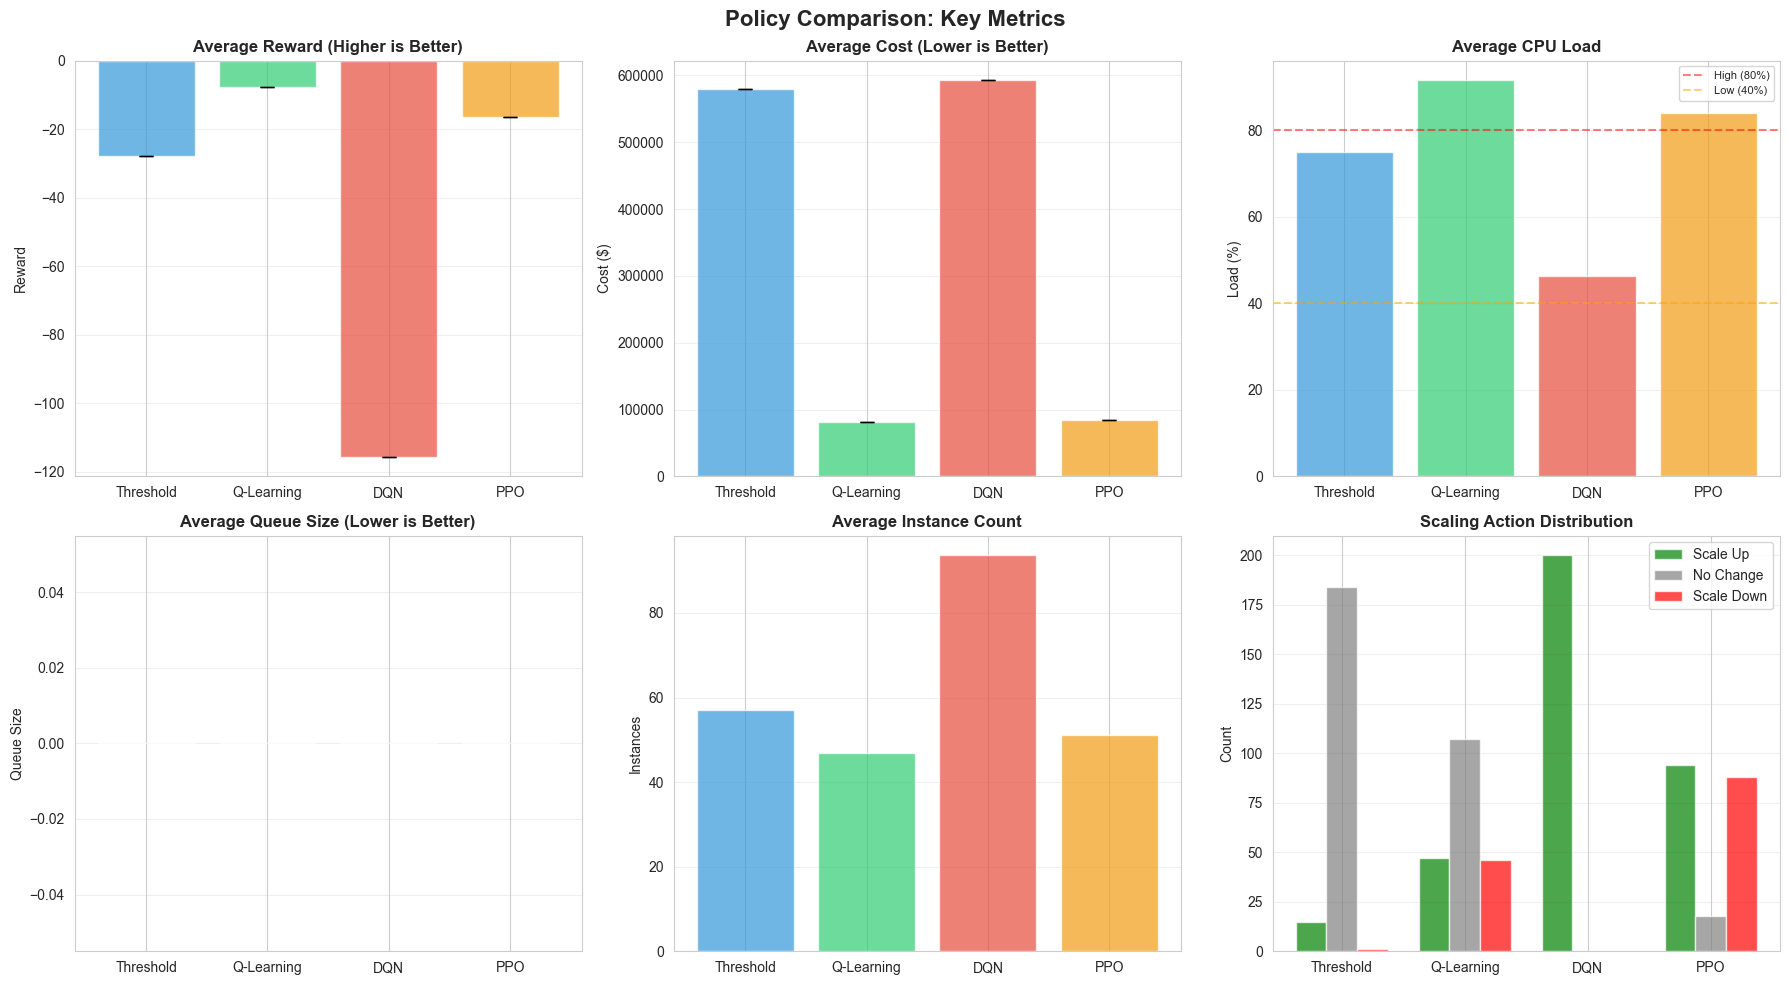

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Policy Comparison: Key Metrics', fontsize=16, fontweight='bold')

policies = list(results.keys())
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(policies)]

# 1. Average Reward
rewards = [results[p]['avg_reward'] for p in policies]
reward_stds = [results[p]['std_reward'] for p in policies]
axes[0, 0].bar(policies, rewards, yerr=reward_stds, color=colors, alpha=0.7, capsize=5)
axes[0, 0].set_title('Average Reward (Higher is Better)', fontweight='bold')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# 2. Average Cost
costs = [results[p]['avg_cost'] for p in policies]
cost_stds = [results[p]['std_cost'] for p in policies]
axes[0, 1].bar(policies, costs, yerr=cost_stds, color=colors, alpha=0.7, capsize=5)
axes[0, 1].set_title('Average Cost (Lower is Better)', fontweight='bold')
axes[0, 1].set_ylabel('Cost ($)')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Average Load
loads = [results[p]['avg_load'] for p in policies]
axes[0, 2].bar(policies, loads, color=colors, alpha=0.7)
axes[0, 2].set_title('Average CPU Load', fontweight='bold')
axes[0, 2].set_ylabel('Load (%)')
axes[0, 2].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='High (80%)')
axes[0, 2].axhline(y=40, color='orange', linestyle='--', alpha=0.5, label='Low (40%)')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Average Queue
queues = [results[p]['avg_queue'] for p in policies]
axes[1, 0].bar(policies, queues, color=colors, alpha=0.7)
axes[1, 0].set_title('Average Queue Size (Lower is Better)', fontweight='bold')
axes[1, 0].set_ylabel('Queue Size')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Average Instances
instances = [results[p]['avg_instances'] for p in policies]
axes[1, 1].bar(policies, instances, color=colors, alpha=0.7)
axes[1, 1].set_title('Average Instance Count', fontweight='bold')
axes[1, 1].set_ylabel('Instances')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Scaling Actions
scale_ups = [results[p]['num_scale_ups'] for p in policies]
scale_downs = [results[p]['num_scale_downs'] for p in policies]
no_change = [results[p]['num_no_change'] for p in policies]

x = np.arange(len(policies))
width = 0.25
axes[1, 2].bar(x - width, scale_ups, width, label='Scale Up', color='green', alpha=0.7)
axes[1, 2].bar(x, no_change, width, label='No Change', color='gray', alpha=0.7)
axes[1, 2].bar(x + width, scale_downs, width, label='Scale Down', color='red', alpha=0.7)
axes[1, 2].set_title('Scaling Action Distribution', fontweight='bold')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(policies)
axes[1, 2].legend()
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Visualization: Time Series Comparison (First Episode)

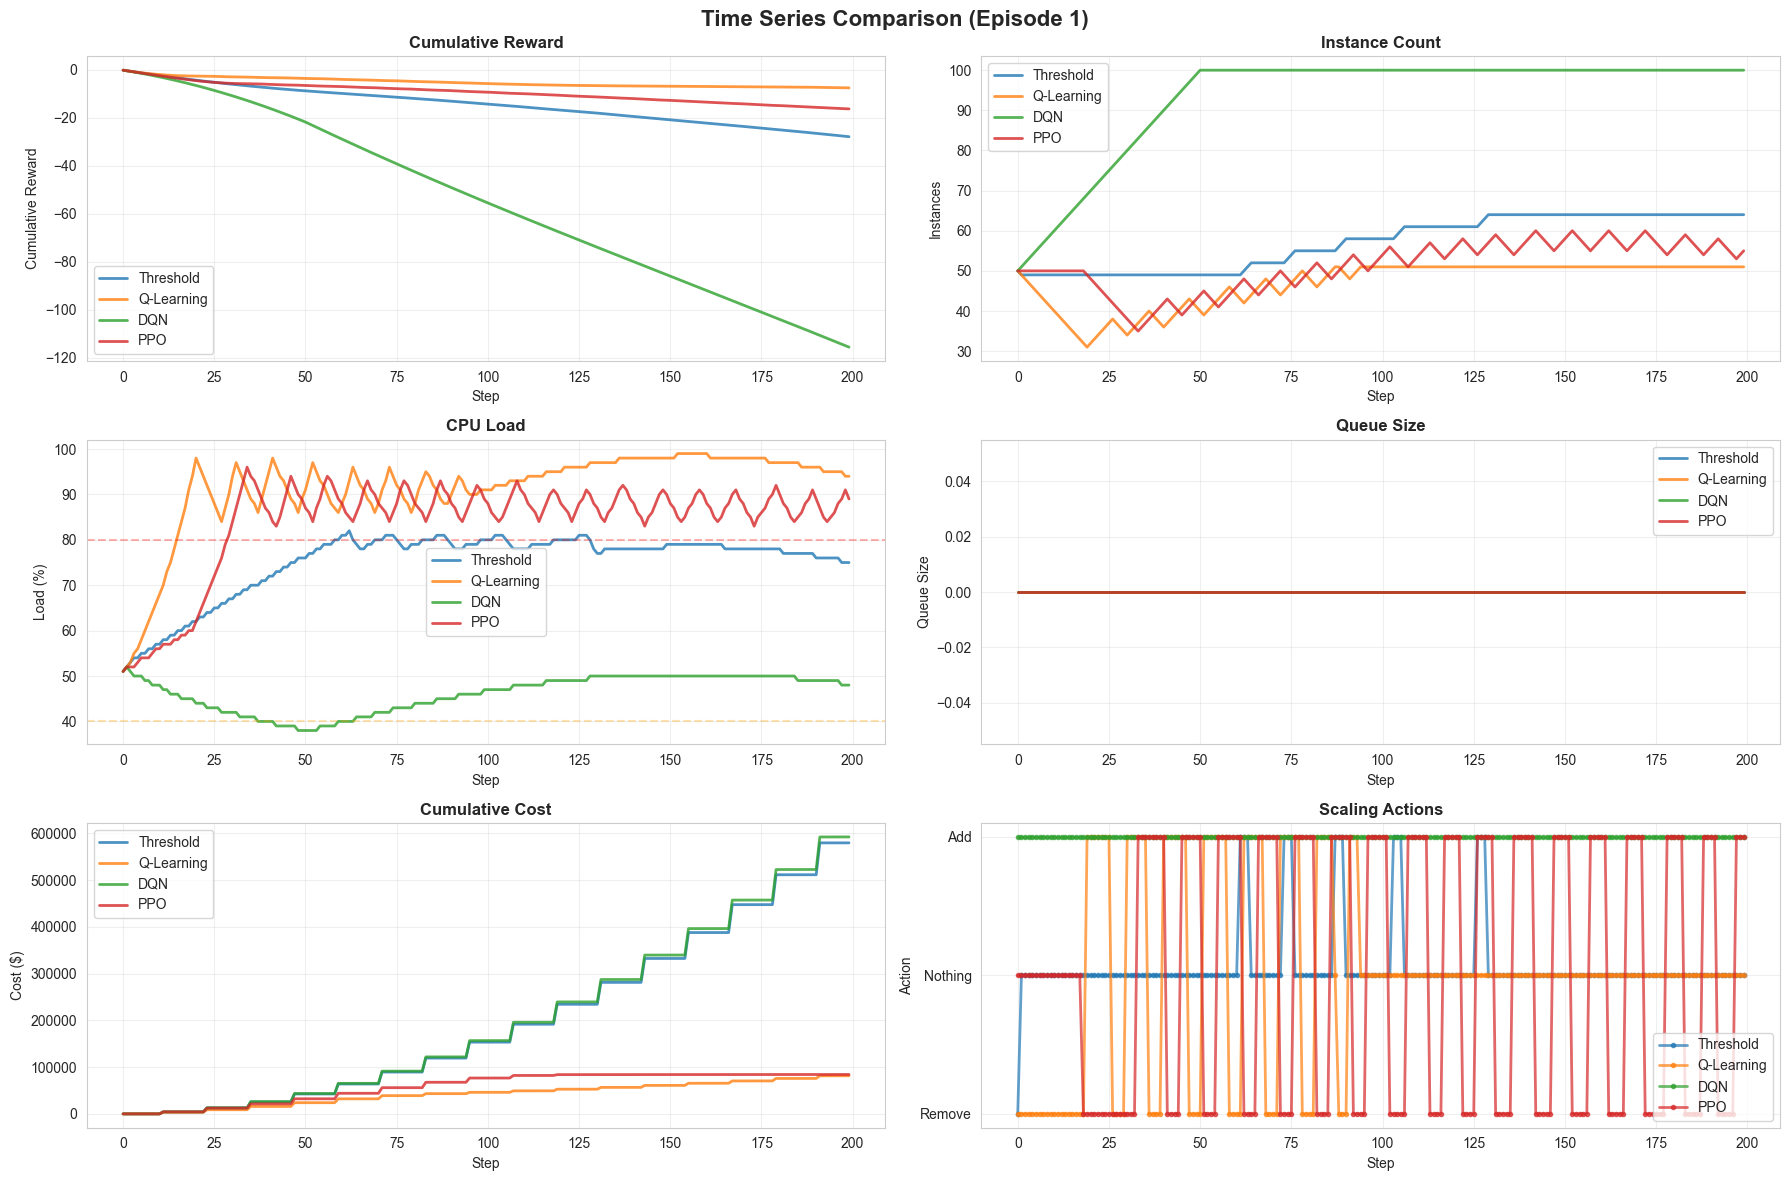

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Time Series Comparison (Episode 1)', fontsize=16, fontweight='bold')

for policy_name, result in results.items():
    ep = result['episodes'][0]  # First episode
    steps = range(len(ep['rewards']))
    
    # 1. Cumulative Reward
    axes[0, 0].plot(steps, np.cumsum(ep['rewards']), label=policy_name, linewidth=2, alpha=0.8)
    
    # 2. Instance Count
    axes[0, 1].plot(steps, ep['instances'], label=policy_name, linewidth=2, alpha=0.8)
    
    # 3. CPU Load
    axes[1, 0].plot(steps, ep['load'], label=policy_name, linewidth=2, alpha=0.8)
    
    # 4. Queue Size
    axes[1, 1].plot(steps, ep['queue_size'], label=policy_name, linewidth=2, alpha=0.8)
    
    # 5. Cost Over Time
    axes[2, 0].plot(steps, ep['costs'], label=policy_name, linewidth=2, alpha=0.8)
    
    # 6. Scaling Actions
    axes[2, 1].plot(steps, ep['actions'], label=policy_name, linewidth=2, alpha=0.7, marker='o', markersize=3)

# Configure subplots
axes[0, 0].set_title('Cumulative Reward', fontweight='bold')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Cumulative Reward')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].set_title('Instance Count', fontweight='bold')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Instances')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].set_title('CPU Load', fontweight='bold')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Load (%)')
axes[1, 0].axhline(y=80, color='red', linestyle='--', alpha=0.3)
axes[1, 0].axhline(y=40, color='orange', linestyle='--', alpha=0.3)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].set_title('Queue Size', fontweight='bold')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Queue Size')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

axes[2, 0].set_title('Cumulative Cost', fontweight='bold')
axes[2, 0].set_xlabel('Step')
axes[2, 0].set_ylabel('Cost ($)')
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)

axes[2, 1].set_title('Scaling Actions', fontweight='bold')
axes[2, 1].set_xlabel('Step')
axes[2, 1].set_ylabel('Action')
axes[2, 1].set_yticks([-1, 0, 1])
axes[2, 1].set_yticklabels(['Remove', 'Nothing', 'Add'])
axes[2, 1].legend()
axes[2, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Visualization: Load vs Instances Heatmap

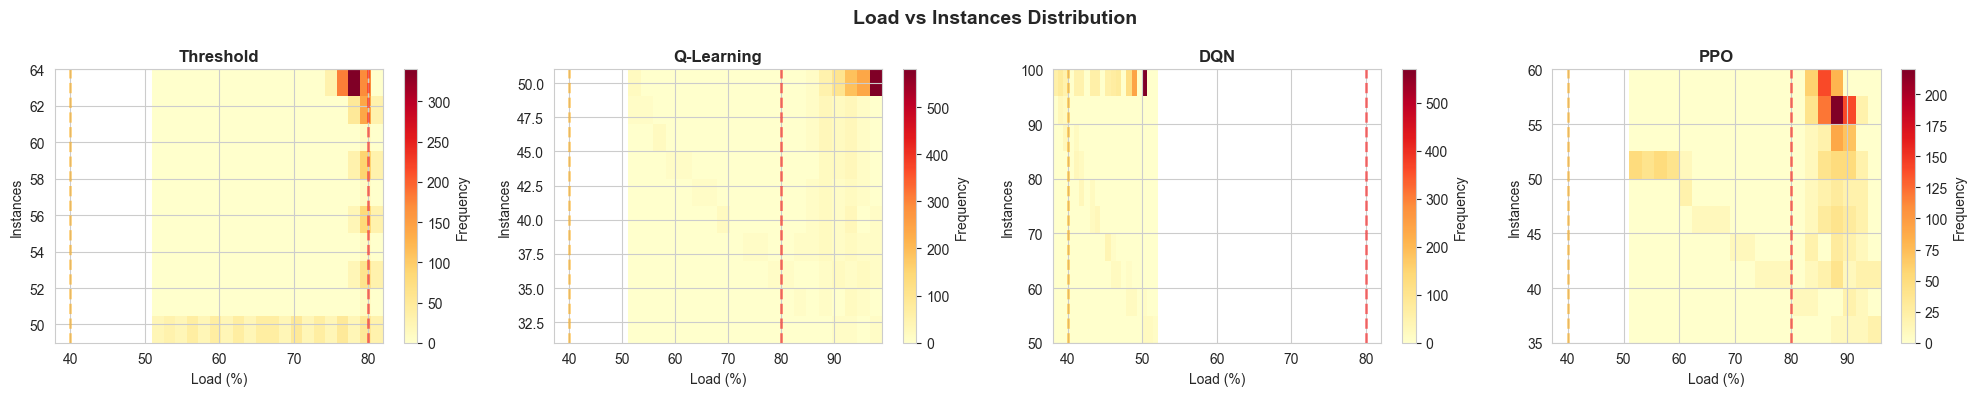

In [30]:
fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 4))
if len(results) == 1:
    axes = [axes]

fig.suptitle('Load vs Instances Distribution', fontsize=14, fontweight='bold')

for idx, (policy_name, result) in enumerate(results.items()):
    # Collect all load and instance data
    all_loads = []
    all_instances = []
    for ep in result['episodes']:
        all_loads.extend(ep['load'])
        all_instances.extend(ep['instances'])
    
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(all_loads, all_instances, bins=[20, 10])
    
    im = axes[idx].imshow(h.T, origin='lower', aspect='auto', cmap='YlOrRd',
                          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axes[idx].set_title(policy_name, fontweight='bold')
    axes[idx].set_xlabel('Load (%)')
    axes[idx].set_ylabel('Instances')
    axes[idx].axvline(x=80, color='red', linestyle='--', alpha=0.5, linewidth=2)
    axes[idx].axvline(x=40, color='orange', linestyle='--', alpha=0.5, linewidth=2)
    plt.colorbar(im, ax=axes[idx], label='Frequency')

plt.tight_layout()
plt.show()

## 11. Visualization: Performance Distribution (Box Plots)

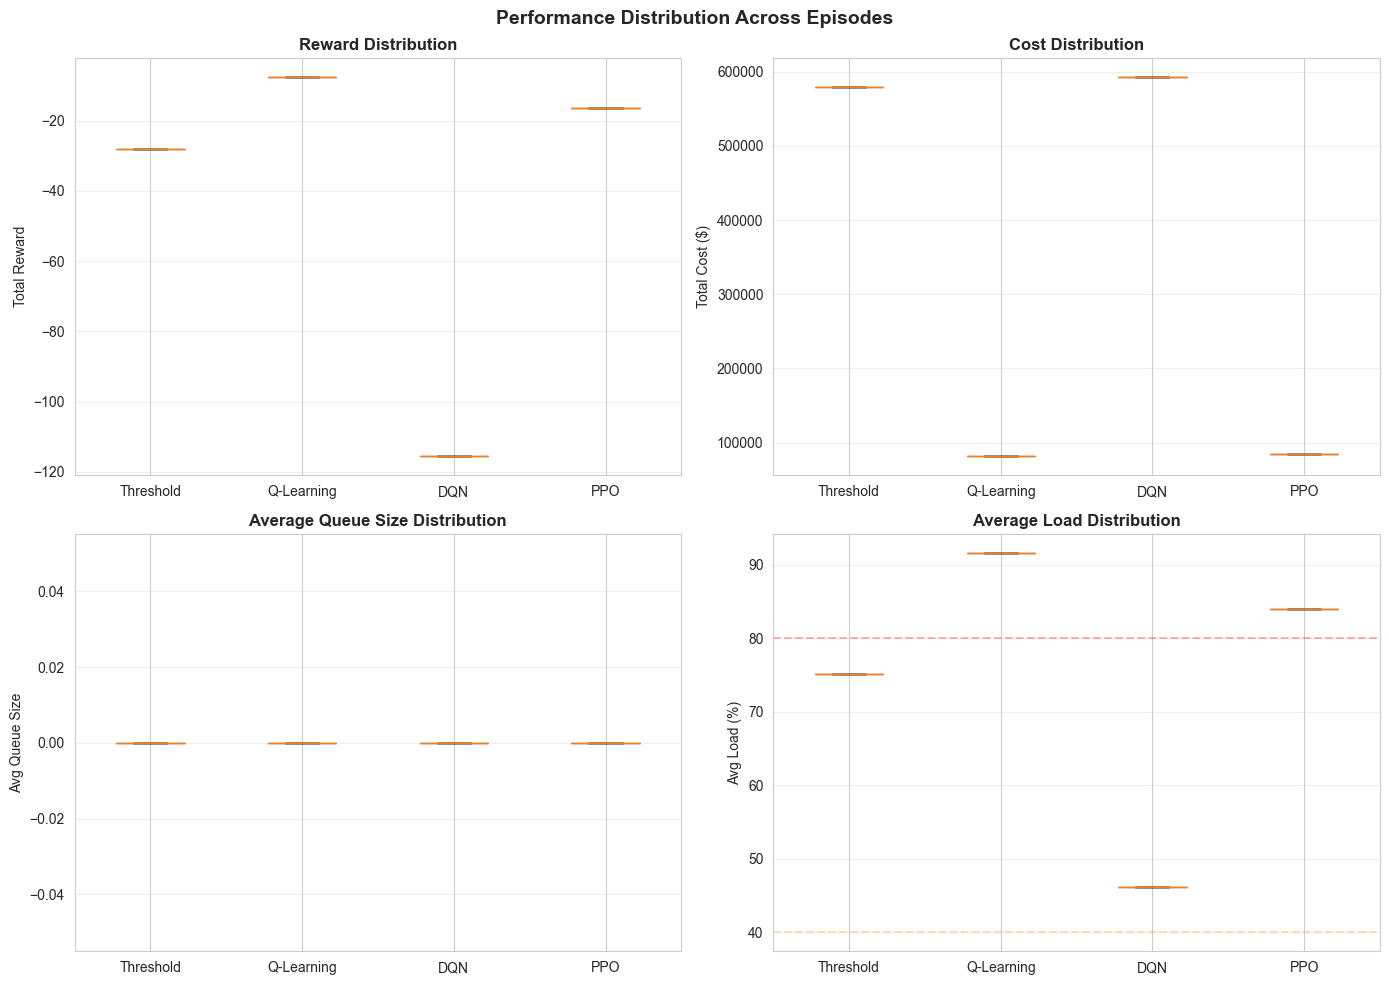

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Distribution Across Episodes', fontsize=14, fontweight='bold')

# Prepare data for box plots
reward_data = []
cost_data = []
queue_data = []
load_data = []

for policy_name, result in results.items():
    reward_data.append([sum(ep['rewards']) for ep in result['episodes']])
    cost_data.append([ep['costs'][-1] for ep in result['episodes']])
    queue_data.append([np.mean(ep['queue_size']) for ep in result['episodes']])
    load_data.append([np.mean(ep['load']) for ep in result['episodes']])

policies = list(results.keys())

# 1. Reward distribution
bp1 = axes[0, 0].boxplot(reward_data, labels=policies, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 0].set_title('Reward Distribution', fontweight='bold')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Cost distribution
bp2 = axes[0, 1].boxplot(cost_data, labels=policies, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_title('Cost Distribution', fontweight='bold')
axes[0, 1].set_ylabel('Total Cost ($)')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Queue distribution
bp3 = axes[1, 0].boxplot(queue_data, labels=policies, patch_artist=True)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_title('Average Queue Size Distribution', fontweight='bold')
axes[1, 0].set_ylabel('Avg Queue Size')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Load distribution
bp4 = axes[1, 1].boxplot(load_data, labels=policies, patch_artist=True)
for patch, color in zip(bp4['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title('Average Load Distribution', fontweight='bold')
axes[1, 1].set_ylabel('Avg Load (%)')
axes[1, 1].axhline(y=80, color='red', linestyle='--', alpha=0.3)
axes[1, 1].axhline(y=40, color='orange', linestyle='--', alpha=0.3)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## calculate Latency metrics

In [32]:
# Calculate latency metrics for all policies
import numpy as np

def calculate_latency_metrics(results):
    """Calculate latency metrics from queue size and load"""
    latency_metrics = {}
    
    for policy_name, result in results.items():
        all_latencies = []
        
        for ep in result['episodes']:
            # Estimate latency based on queue size and load
            # Latency = base_latency + queue_penalty
            base_latency = 10  # ms base latency
            for i in range(len(ep['queue_size'])):
                queue = ep['queue_size'][i]
                load = ep['load'][i]
                instances = ep['instances'][i]
                
                # Calculate latency: higher queue = higher latency
                # Also factor in load per instance
                load_per_instance = load / max(instances, 1)
                latency = base_latency + (queue * 0.5) + (load_per_instance * 20)
                all_latencies.append(latency)
        
        latency_metrics[policy_name] = {
            'mean': np.mean(all_latencies),
            'median': np.median(all_latencies),
            'p95': np.percentile(all_latencies, 95),
            'p99': np.percentile(all_latencies, 99),
            'max': np.max(all_latencies),
            'all_latencies': all_latencies
        }
    
    return latency_metrics

latency_metrics = calculate_latency_metrics(results)

# Display latency metrics table
print("\n" + "="*80)
print("LATENCY METRICS (milliseconds)")
print("="*80)
print(f"{'Policy':<15} {'Mean':<10} {'Median':<10} {'P95':<10} {'P99':<10} {'Max':<10}")
print("-"*80)
for policy_name, metrics in latency_metrics.items():
    print(f"{policy_name:<15} {metrics['mean']:>9.2f} {metrics['median']:>9.2f} "
          f"{metrics['p95']:>9.2f} {metrics['p99']:>9.2f} {metrics['max']:>9.2f}")
print("="*80)



LATENCY METRICS (milliseconds)
Policy          Mean       Median     P95        P99        Max       
--------------------------------------------------------------------------------
Threshold           36.46     35.81     41.45     42.80     43.06
Q-Learning          49.64     48.43     62.73     68.21     71.25
DQN                 20.16     19.80     26.01     29.62     30.40
PPO                 43.29     42.50     54.88     60.83     63.33


## SLA violation analysis

In [33]:
# Calculate SLA violations
def calculate_sla_violations(results, latency_metrics, sla_threshold_ms=100):
    """Calculate SLA violations based on latency threshold"""
    sla_violations = {}
    
    for policy_name, result in results.items():
        latencies = latency_metrics[policy_name]['all_latencies']
        violations = sum(1 for lat in latencies if lat > sla_threshold_ms)
        total_requests = len(latencies)
        violation_rate = (violations / total_requests) * 100
        
        sla_violations[policy_name] = {
            'total_violations': violations,
            'total_requests': total_requests,
            'violation_rate': violation_rate,
            'sla_compliance': 100 - violation_rate
        }
    
    return sla_violations

sla_threshold = 100  # ms
sla_violations = calculate_sla_violations(results, latency_metrics, sla_threshold)

# Display SLA violations
print("\n" + "="*80)
print(f"SLA VIOLATION ANALYSIS (Threshold: {sla_threshold}ms)")
print("="*80)
print(f"{'Policy':<15} {'Violations':<12} {'Total Req':<12} {'Violation %':<12} {'Compliance %':<12}")
print("-"*80)
for policy_name, metrics in sla_violations.items():
    print(f"{policy_name:<15} {metrics['total_violations']:<12} "
          f"{metrics['total_requests']:<12} {metrics['violation_rate']:>11.2f}% "
          f"{metrics['sla_compliance']:>11.2f}%")
print("="*80)



SLA VIOLATION ANALYSIS (Threshold: 100ms)
Policy          Violations   Total Req    Violation %  Compliance %
--------------------------------------------------------------------------------
Threshold       0            2000                0.00%      100.00%
Q-Learning      0            2000                0.00%      100.00%
DQN             0            2000                0.00%      100.00%
PPO             0            2000                0.00%      100.00%


## Latency comparision BAR chart

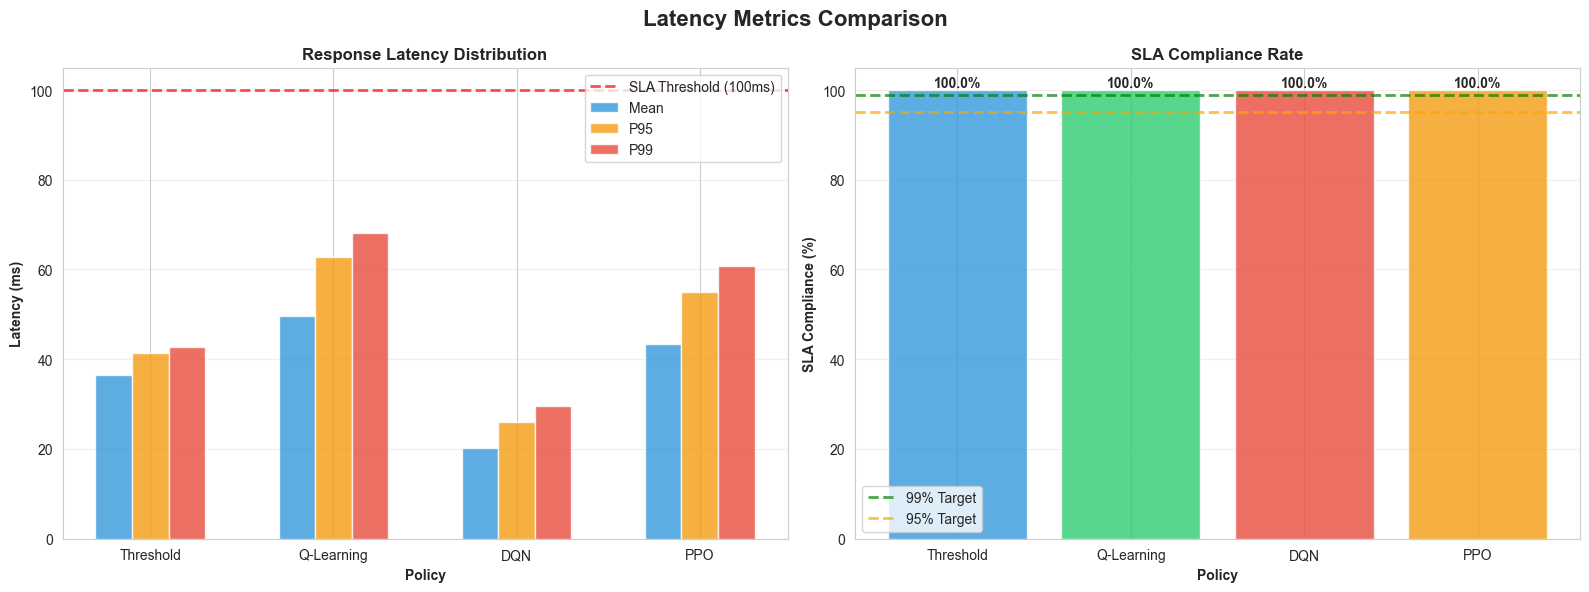

In [34]:
# Visualize latency metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Latency Metrics Comparison', fontsize=16, fontweight='bold')

policies = list(latency_metrics.keys())
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(policies)]

# Plot 1: Average and Tail Latencies
x = np.arange(len(policies))
width = 0.2

means = [latency_metrics[p]['mean'] for p in policies]
p95s = [latency_metrics[p]['p95'] for p in policies]
p99s = [latency_metrics[p]['p99'] for p in policies]

axes[0].bar(x - width, means, width, label='Mean', color='#3498db', alpha=0.8)
axes[0].bar(x, p95s, width, label='P95', color='#f39c12', alpha=0.8)
axes[0].bar(x + width, p99s, width, label='P99', color='#e74c3c', alpha=0.8)

axes[0].axhline(y=sla_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'SLA Threshold ({sla_threshold}ms)', alpha=0.7)
axes[0].set_xlabel('Policy', fontweight='bold')
axes[0].set_ylabel('Latency (ms)', fontweight='bold')
axes[0].set_title('Response Latency Distribution', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(policies)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: SLA Compliance
compliance_rates = [sla_violations[p]['sla_compliance'] for p in policies]
bars = axes[1].bar(policies, compliance_rates, color=colors, alpha=0.8)
axes[1].axhline(y=99, color='green', linestyle='--', linewidth=2, 
                label='99% Target', alpha=0.7)
axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=2, 
                label='95% Target', alpha=0.7)
axes[1].set_xlabel('Policy', fontweight='bold')
axes[1].set_ylabel('SLA Compliance (%)', fontweight='bold')
axes[1].set_title('SLA Compliance Rate', fontweight='bold')
axes[1].set_ylim([0, 105])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## Ltency Over Time Plot

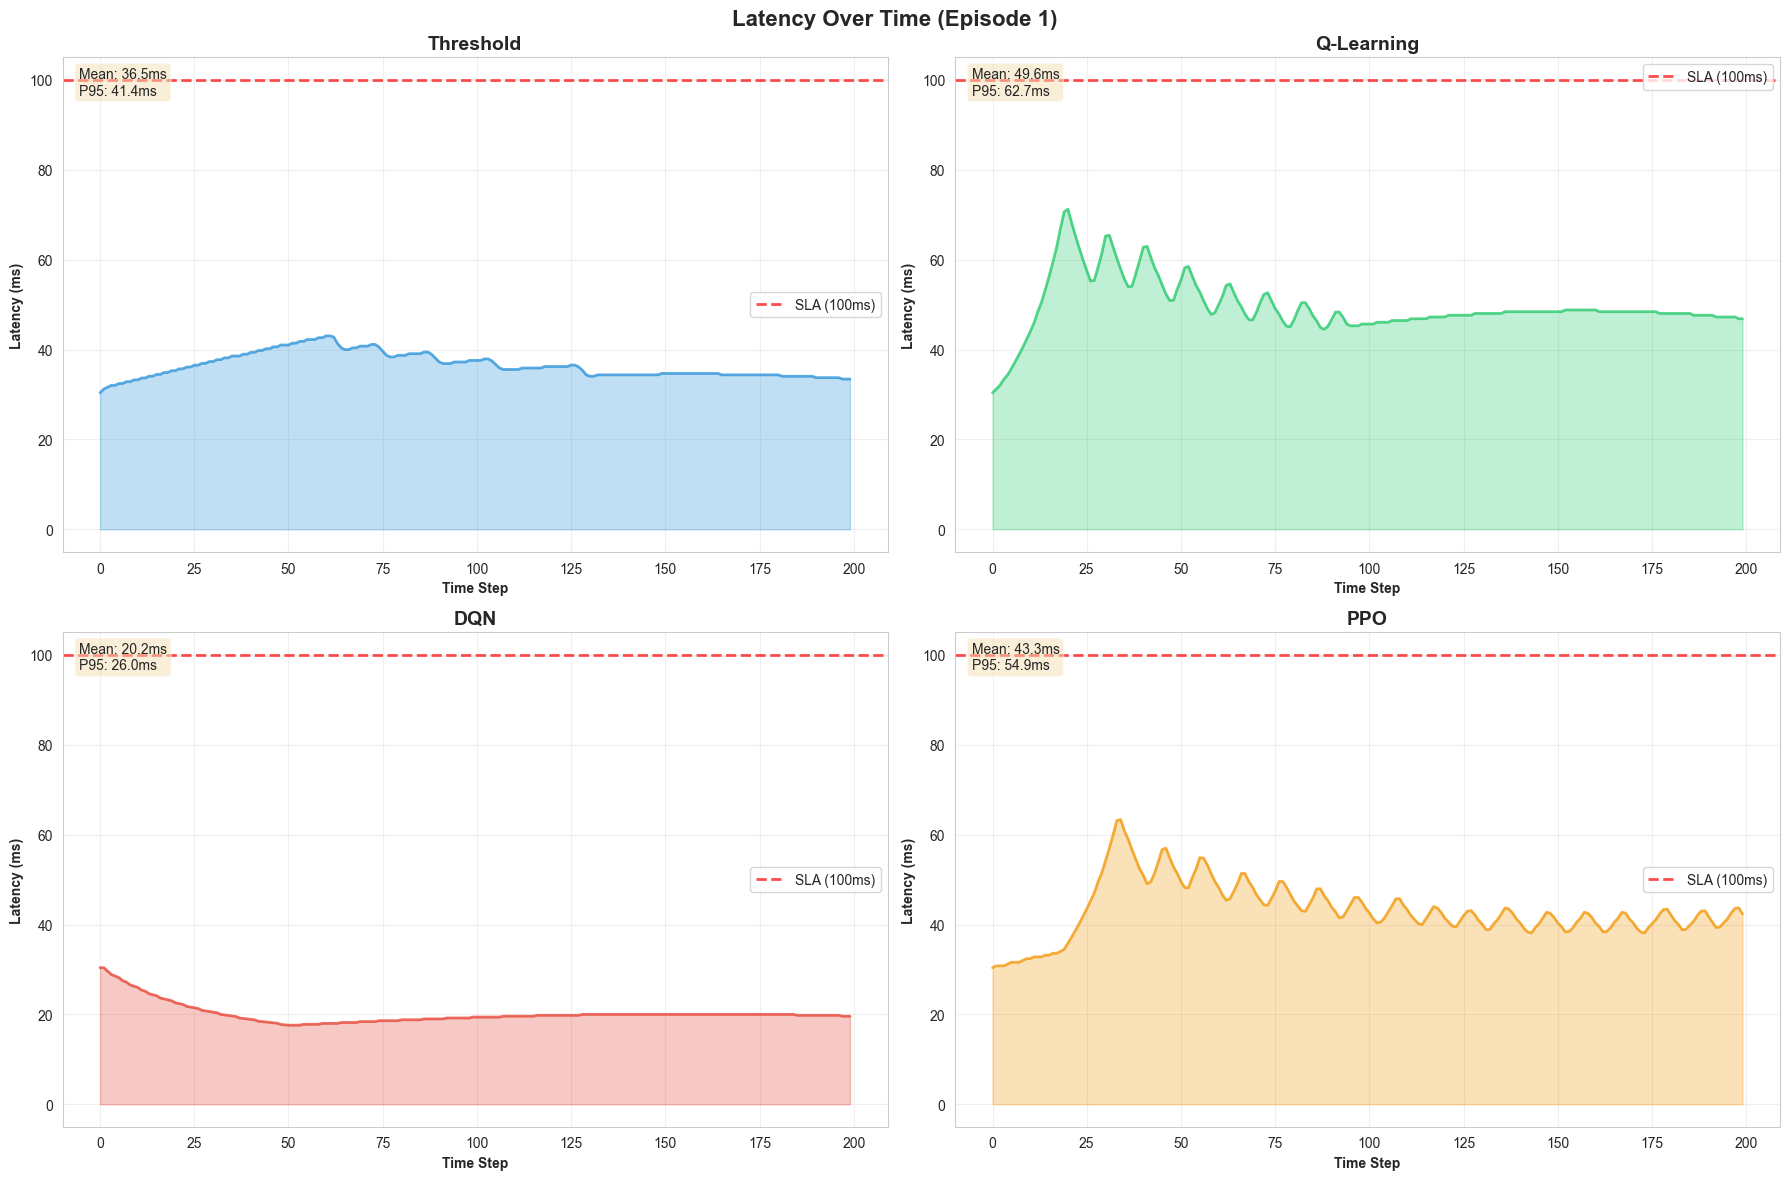

In [35]:
# Plot latency over time for first episode
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Latency Over Time (Episode 1)', fontsize=16, fontweight='bold')

for idx, (policy_name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
    
    ep = result['episodes'][0]
    steps = range(len(ep['queue_size']))
    
    # Calculate latency for this episode
    latencies = []
    base_latency = 10
    for i in range(len(ep['queue_size'])):
        queue = ep['queue_size'][i]
        load = ep['load'][i]
        instances = ep['instances'][i]
        load_per_instance = load / max(instances, 1)
        latency = base_latency + (queue * 0.5) + (load_per_instance * 20)
        latencies.append(latency)
    
    # Plot latency
    axes[row, col].plot(steps, latencies, linewidth=2, color=colors[idx], alpha=0.8)
    axes[row, col].axhline(y=sla_threshold, color='red', linestyle='--', 
                           linewidth=2, label=f'SLA ({sla_threshold}ms)', alpha=0.7)
    axes[row, col].fill_between(steps, 0, latencies, alpha=0.3, color=colors[idx])
    
    axes[row, col].set_title(f'{policy_name}', fontweight='bold', fontsize=14)
    axes[row, col].set_xlabel('Time Step', fontweight='bold')
    axes[row, col].set_ylabel('Latency (ms)', fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)
    
    # Add statistics text
    mean_lat = np.mean(latencies)
    p95_lat = np.percentile(latencies, 95)
    axes[row, col].text(0.02, 0.98, 
                       f'Mean: {mean_lat:.1f}ms\nP95: {p95_lat:.1f}ms',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## Queue lenghth Over time

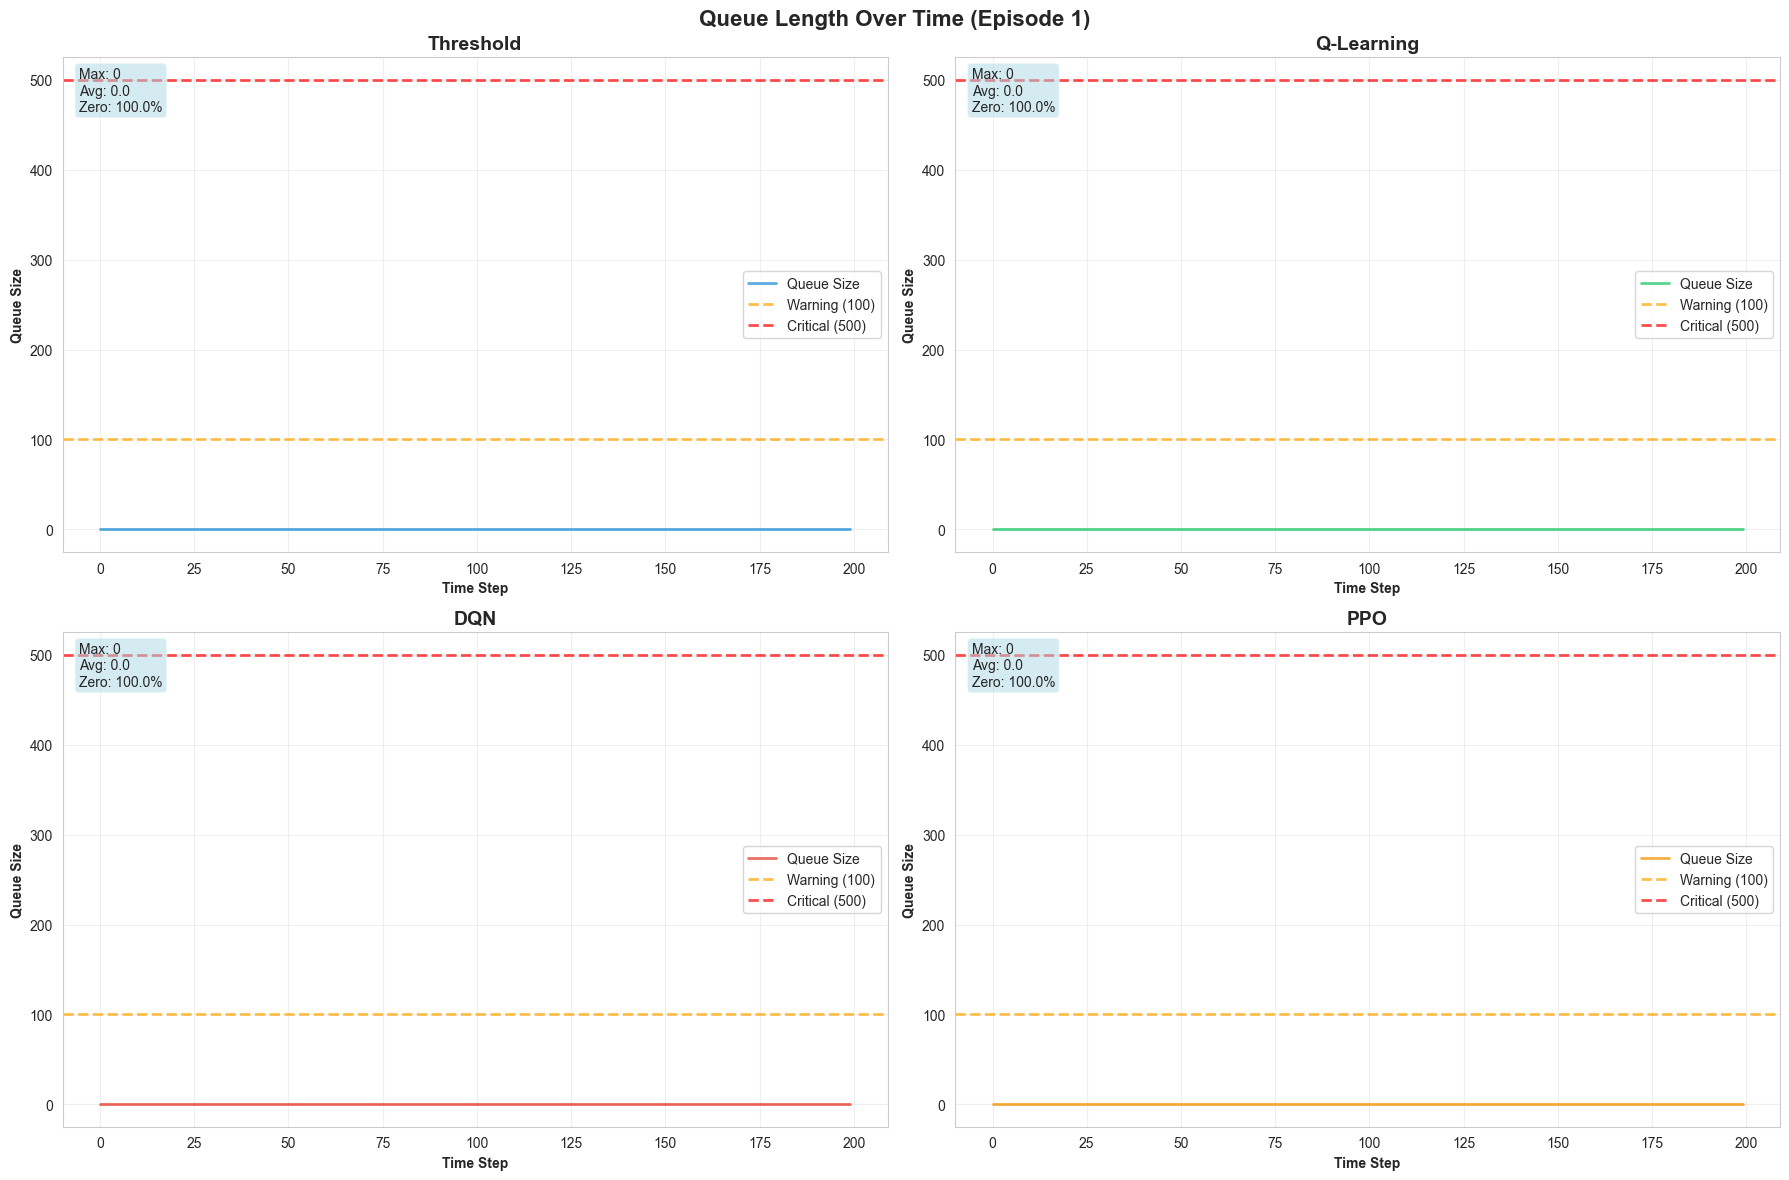

In [36]:
# Detailed queue length analysis over time
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Queue Length Over Time (Episode 1)', fontsize=16, fontweight='bold')

for idx, (policy_name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
    
    ep = result['episodes'][0]
    steps = range(len(ep['queue_size']))
    
    # Plot queue size
    axes[row, col].plot(steps, ep['queue_size'], linewidth=2, 
                       color=colors[idx], label='Queue Size', alpha=0.8)
    axes[row, col].fill_between(steps, 0, ep['queue_size'], 
                                alpha=0.3, color=colors[idx])
    
    # Add warning threshold
    axes[row, col].axhline(y=100, color='orange', linestyle='--', 
                          linewidth=2, label='Warning (100)', alpha=0.7)
    axes[row, col].axhline(y=500, color='red', linestyle='--', 
                          linewidth=2, label='Critical (500)', alpha=0.7)
    
    axes[row, col].set_title(f'{policy_name}', fontweight='bold', fontsize=14)
    axes[row, col].set_xlabel('Time Step', fontweight='bold')
    axes[row, col].set_ylabel('Queue Size', fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)
    
    # Add statistics
    max_queue = np.max(ep['queue_size'])
    avg_queue = np.mean(ep['queue_size'])
    pct_zero = (sum(1 for q in ep['queue_size'] if q == 0) / len(ep['queue_size'])) * 100
    
    axes[row, col].text(0.02, 0.98, 
                       f'Max: {max_queue:.0f}\nAvg: {avg_queue:.1f}\nZero: {pct_zero:.1f}%',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()


## Combined performance dashboard

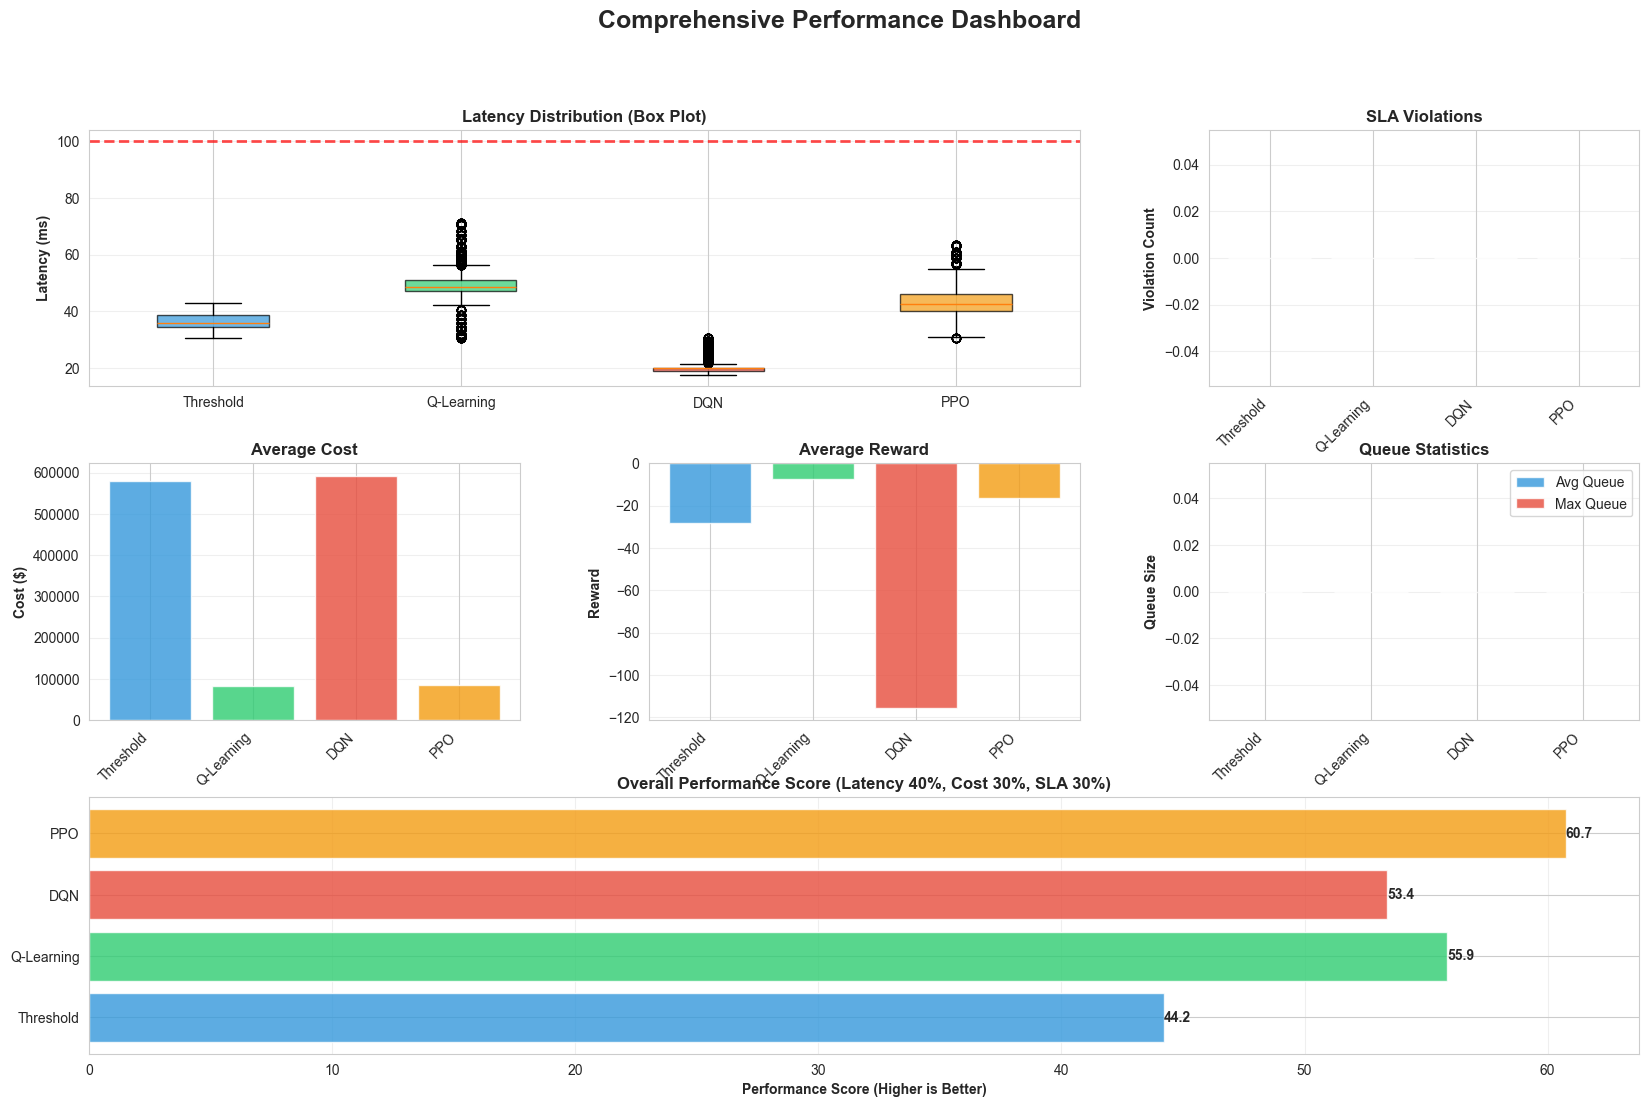

In [37]:
# Create comprehensive performance dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Comprehensive Performance Dashboard', fontsize=18, fontweight='bold')

# 1. Latency Box Plot
ax1 = fig.add_subplot(gs[0, :2])
latency_data = [latency_metrics[p]['all_latencies'] for p in policies]
bp = ax1.boxplot(latency_data, labels=policies, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.axhline(y=sla_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_ylabel('Latency (ms)', fontweight='bold')
ax1.set_title('Latency Distribution (Box Plot)', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. SLA Violations
ax2 = fig.add_subplot(gs[0, 2])
violations = [sla_violations[p]['total_violations'] for p in policies]
ax2.bar(policies, violations, color=colors, alpha=0.8)
ax2.set_ylabel('Violation Count', fontweight='bold')
ax2.set_title('SLA Violations', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Average Cost
ax3 = fig.add_subplot(gs[1, 0])
costs = [results[p]['avg_cost'] for p in policies]
ax3.bar(policies, costs, color=colors, alpha=0.8)
ax3.set_ylabel('Cost ($)', fontweight='bold')
ax3.set_title('Average Cost', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Average Reward
ax4 = fig.add_subplot(gs[1, 1])
rewards = [results[p]['avg_reward'] for p in policies]
ax4.bar(policies, rewards, color=colors, alpha=0.8)
ax4.set_ylabel('Reward', fontweight='bold')
ax4.set_title('Average Reward', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. Queue Statistics
ax5 = fig.add_subplot(gs[1, 2])
avg_queues = [results[p]['avg_queue'] for p in policies]
max_queues = [results[p]['max_queue'] for p in policies]
x = np.arange(len(policies))
width = 0.35
ax5.bar(x - width/2, avg_queues, width, label='Avg Queue', color='#3498db', alpha=0.8)
ax5.bar(x + width/2, max_queues, width, label='Max Queue', color='#e74c3c', alpha=0.8)
ax5.set_ylabel('Queue Size', fontweight='bold')
ax5.set_title('Queue Statistics', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(policies)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 6. Performance Score (normalized)
ax6 = fig.add_subplot(gs[2, :])
# Calculate composite score (lower is better)
scores = {}
for p in policies:
    # Normalize metrics (0-1 scale, lower is better)
    norm_latency = latency_metrics[p]['p95'] / max(latency_metrics[pol]['p95'] for pol in policies)
    norm_cost = results[p]['avg_cost'] / max(results[pol]['avg_cost'] for pol in policies)
    norm_violations = sla_violations[p]['violation_rate'] / max(sla_violations[pol]['violation_rate'] for pol in policies) if max(sla_violations[pol]['violation_rate'] for pol in policies) > 0 else 0
    
    # Composite score (weighted average)
    score = (0.4 * norm_latency + 0.3 * norm_cost + 0.3 * norm_violations) * 100
    scores[p] = 100 - score  # Invert so higher is better

score_values = [scores[p] for p in policies]
bars = ax6.barh(policies, score_values, color=colors, alpha=0.8)
ax6.set_xlabel('Performance Score (Higher is Better)', fontweight='bold')
ax6.set_title('Overall Performance Score (Latency 40%, Cost 30%, SLA 30%)', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax6.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [38]:
# Create comprehensive summary table
summary_data = []
for policy_name in policies:
    summary_data.append({
        'Policy': policy_name,
        'Avg Latency (ms)': f"{latency_metrics[policy_name]['mean']:.2f}",
        'P95 Latency (ms)': f"{latency_metrics[policy_name]['p95']:.2f}",
        'P99 Latency (ms)': f"{latency_metrics[policy_name]['p99']:.2f}",
        'SLA Violations': sla_violations[policy_name]['total_violations'],
        'SLA Compliance %': f"{sla_violations[policy_name]['sla_compliance']:.2f}",
        'Avg Cost ($)': f"{results[policy_name]['avg_cost']:.2f}",
        'Avg Queue': f"{results[policy_name]['avg_queue']:.2f}",
        'Max Queue': f"{results[policy_name]['max_queue']:.1f}",
        'Avg Reward': f"{results[policy_name]['avg_reward']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*120)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*120)
print(df_summary.to_string(index=False))
print("="*120)

# Save to CSV
df_summary.to_csv('evaluation_summary_detailed.csv', index=False)
print("\n✓ Summary saved to 'evaluation_summary_detailed.csv'")



COMPREHENSIVE PERFORMANCE SUMMARY
    Policy Avg Latency (ms) P95 Latency (ms) P99 Latency (ms)  SLA Violations SLA Compliance % Avg Cost ($) Avg Queue Max Queue Avg Reward
 Threshold            36.46            41.45            42.80               0           100.00    579889.54      0.00       0.0     -27.95
Q-Learning            49.64            62.73            68.21               0           100.00     81483.10      0.00       0.0      -7.62
       DQN            20.16            26.01            29.62               0           100.00    592615.68      0.00       0.0    -115.60
       PPO            43.29            54.88            60.83               0           100.00     84276.77      0.00       0.0     -16.37

✓ Summary saved to 'evaluation_summary_detailed.csv'


## 12. Key Findings and Analysis

In [39]:
print("=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Find best performers
best_reward = max(results.items(), key=lambda x: x[1]['avg_reward'])
best_cost = min(results.items(), key=lambda x: x[1]['avg_cost'])
best_load = max(results.items(), key=lambda x: x[1]['avg_load'])
lowest_queue = min(results.items(), key=lambda x: x[1]['avg_queue'])

print(f"\n🏆 Best Average Reward: {best_reward[0]}")
print(f"   → {best_reward[1]['avg_reward']:.2f} ± {best_reward[1]['std_reward']:.2f}")

print(f"\n💰 Lowest Cost: {best_cost[0]}")
print(f"   → ${best_cost[1]['avg_cost']:.2f} ± ${best_cost[1]['std_cost']:.2f}")

print(f"\n📊 Highest Load Utilization: {best_load[0]}")
print(f"   → {best_load[1]['avg_load']:.1f}%")

print(f"\n⚡ Lowest Queue Size: {lowest_queue[0]}")
print(f"   → {lowest_queue[1]['avg_queue']:.2f}")

# Compare RL vs Threshold
if 'Threshold' in results:
    print(f"\n📈 RL vs Threshold Baseline:")
    threshold_reward = results['Threshold']['avg_reward']
    threshold_cost = results['Threshold']['avg_cost']
    
    for name in ['Q-Learning', 'DQN', 'PPO']:
        if name in results:
            reward_improvement = ((results[name]['avg_reward'] / threshold_reward) - 1) * 100
            cost_improvement = ((threshold_cost / results[name]['avg_cost']) - 1) * 100
            print(f"\n   {name}:")
            print(f"   - Reward improvement: {reward_improvement:+.1f}%")
            print(f"   - Cost improvement: {cost_improvement:+.1f}%")

print("\n" + "=" * 80)
print("✓ EVALUATION COMPLETE")
print("=" * 80)

KEY FINDINGS

🏆 Best Average Reward: Q-Learning
   → -7.62 ± 0.00

💰 Lowest Cost: Q-Learning
   → $81483.10 ± $0.00

📊 Highest Load Utilization: Q-Learning
   → 91.5%

⚡ Lowest Queue Size: Threshold
   → 0.00

📈 RL vs Threshold Baseline:

   Q-Learning:
   - Reward improvement: -72.8%
   - Cost improvement: +611.7%

   DQN:
   - Reward improvement: +313.5%
   - Cost improvement: -2.1%

   PPO:
   - Reward improvement: -41.5%
   - Cost improvement: +588.1%

✓ EVALUATION COMPLETE


## 13. Save Results

In [40]:
# Save results to file
import json

results_to_save = {}
for name, result in results.items():
    results_to_save[name] = {
        'avg_reward': float(result['avg_reward']),
        'std_reward': float(result['std_reward']),
        'avg_cost': float(result['avg_cost']),
        'std_cost': float(result['std_cost']),
        'avg_load': float(result['avg_load']),
        'avg_queue': float(result['avg_queue']),
        'max_queue': float(result['max_queue']),
        'avg_instances': float(result['avg_instances']),
        'num_scale_ups': float(result['num_scale_ups']),
        'num_scale_downs': float(result['num_scale_downs']),
        'num_no_change': float(result['num_no_change'])
    }

with open('evaluation_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print("✓ Results saved to evaluation_results.json")

# Also save as CSV
df_summary.to_csv('evaluation_summary.csv', index=False)
print("✓ Summary saved to evaluation_summary.csv")

✓ Results saved to evaluation_results.json
✓ Summary saved to evaluation_summary.csv
